# 🧪 Fertilizer Dosage Prediction Pipeline (Tunisia)

This notebook presents a complete machine learning workflow to **predict optimal fertilizer dosage** using real-world agricultural data from Tunisia.

### 📌 Key Components:
- **Exploratory Data Analysis (EDA)**: Understand data distributions and correlations
- **Data Preprocessing**: Handle missing values, outliers, skewness, and encoding
- **Feature Engineering**: Create interaction features and nutrient deficit metrics
- **Modeling & Tuning**: Random Forest, XGBoost, and Ridge Regression with `RandomizedSearchCV`
- **Evaluation**: MAE, RMSE, R², and insights into important predictors

> 🚜 Goal: Deliver accurate and interpretable fertilizer dosage recommendations for Tunisian crops and soils.


# **Data understanding**

In [1]:
from google.colab import files
import pandas as pd

# Upload file manually
uploaded = files.upload()

Saving augmented.csv to augmented (1).csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import missingno as msno

In [3]:
data = pd.read_csv('augmented.csv', delimiter=';', encoding='utf-8')
print(data.shape)

# Display sample data and info
display(data.head())
data.info()
print(data.describe())


(19215, 20)


,Fertilizer Name,N (%),P (%),K (%),Fertilizer Type,Absorption Rate (%),Price per kg (TND),Region of Use in Tunisia,State,Specific Crop,Crop N,Crop P,Crop K,Application Method,Root Depth (cm),Soil_P,Soil_K,Soil_N,pH,Usage (Dosage)
0,GLYBET,20.0,10.0,10.0,Liquid,80.0,5.0,North,Ariana,Citrus Fruits,150.0,40.0,105.0,Radicular and Foliar,75.0,24.625694,245.393176,118.616634,8.10,156.0
1,BOMBARDIER,10.0,15.0,15.0,Organic,85.0,10.5,North,Ariana,Citrus Fruits,150.0,40.0,105.0,Radicular and Foliar,75.0,18.250959,158.432766,285.707149,8.30,150.0
2,ACM MAR S,15.0,10.0,10.0,Granular,90.0,14.5,North,Ariana,Citrus Fruits,150.0,40.0,105.0,Foliar,75.0,47.680399,153.957211,222.278243,8.60,291.0
3,HUMIFERT LIQUID,10.0,10.0,10.0,Liquid,50.0,8.5,North,Ariana,Citrus Fruits,150.0,40.0,105.0,Radicular and Foliar,75.0,39.362261,192.056831,183.610960,8.48,107.0
4,HUMIFERT LIQUID,10.0,10.0,10.0,Liquid,50.0,8.5,North,Ariana,Citrus Fruits,150.0,40.0,105.0,Radicular and Foliar,75.0,11.305093,206.707051,55.245406,8.00,82.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19215 entries, 0 to 19214
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Fertilizer Name           19215 non-null  object 
 1   N (%)                     19215 non-null  float64
 2   P (%)                     19215 non-null  float64
 3   K (%)                     19215 non-null  float64
 4   Fertilizer Type           19215 non-null  object 
 5   Absorption Rate (%)       19215 non-null  float64
 6   Price per kg (TND)        19215 non-null  float64
 7   Region of Use in Tunisia  19215 non-null  object 
 8   State                     19215 non-null  object 
 9   Specific Crop             19215 non-null  object 
 10  Crop N                    19215 non-null  float64
 11  Crop P                    19215 non-null  float64
 12  Crop K                    19215 non-null  float64
 13  Application Method        19215 non-null  object 
 14  Root D

In [4]:
data.shape

(19215, 20)

In [5]:
# Check for missing values
missing = data.isnull().sum()
print("Missing values:\n", missing[missing > 0])


Missing values:
 Series([], dtype: int64)


## **Data Understanding & EDA**

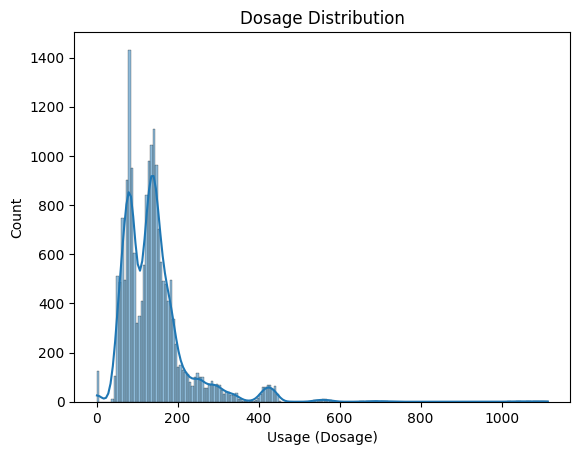

In [6]:
# Target distribution
sns.histplot(data['Usage (Dosage)'], kde=True)
plt.title('Dosage Distribution')
plt.show()

The histogram shows a right-skewed distribution of fertilizer dosages, with most values between 50-150 kg/ha or L/ha. There are some high-dosage outliers above 600. The KDE line suggests a primary peak around 100 and a smaller one near 400, possibly indicating two usage patterns.

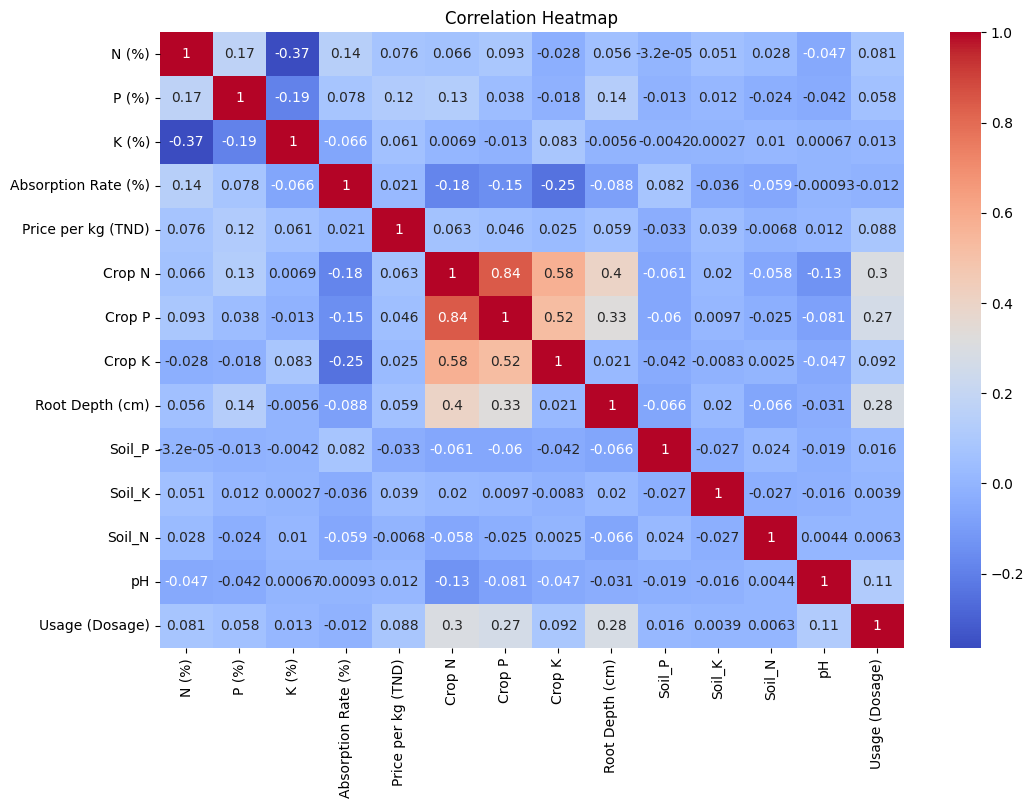

In [7]:
# Correlation heatmap
numeric_cols = data.select_dtypes(include=np.number)
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_cols.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()



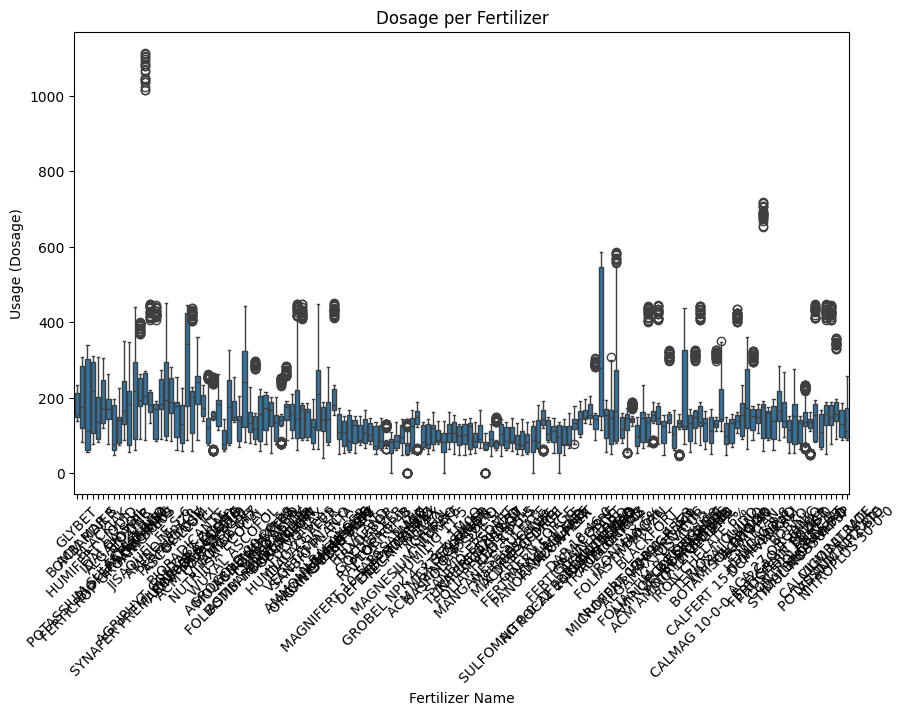

In [8]:
# Boxplot of dosage by fertilizer
plt.figure(figsize=(10, 6))
sns.boxplot(data=data, x='Fertilizer Name', y='Usage (Dosage)')
plt.xticks(rotation=45)
plt.title("Dosage per Fertilizer")
plt.show()

Text(0.5, 1.0, 'Nitrogen (N) Distribution')

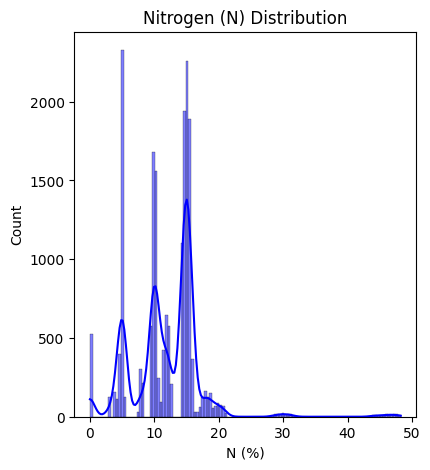

In [9]:
# =============================================
# 3. EXPLORATORY DATA ANALYSIS (EDA)
# =============================================

# Nutrient composition analysis
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.histplot(data['N (%)'], kde=True, color='blue')
plt.title('Nitrogen (N) Distribution')



Text(0.5, 1.0, 'Phosphorus (P) Distribution')

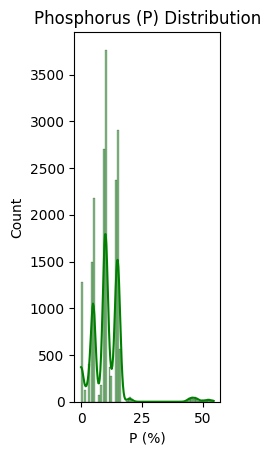

In [10]:
plt.subplot(1, 3, 2)
sns.histplot(data['P (%)'], kde=True, color='green')
plt.title('Phosphorus (P) Distribution')



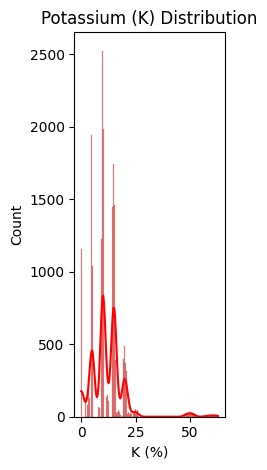

In [11]:
plt.subplot(1, 3, 3)
sns.histplot(data['K (%)'], kde=True, color='red')
plt.title('Potassium (K) Distribution')
plt.tight_layout()
plt.show()

<ipython-input-12-6b8539a69c21>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Fertilizer Type', data=data, palette='viridis')


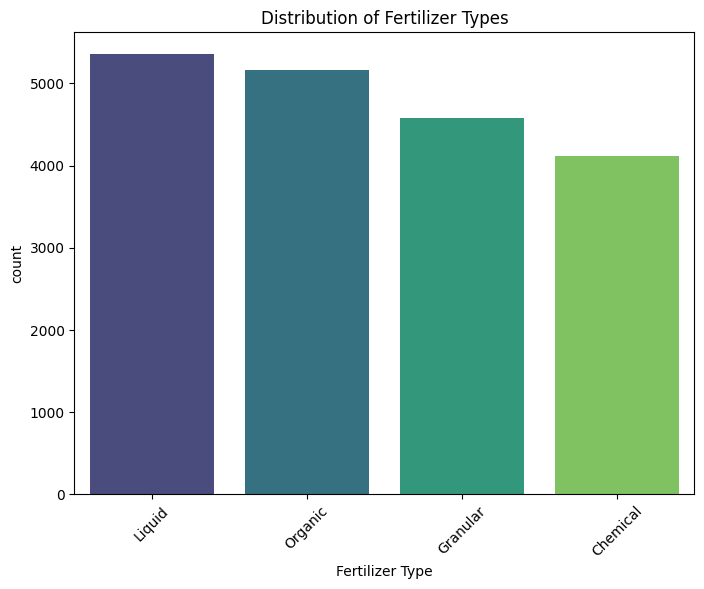

In [12]:
# Fertilizer type distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='Fertilizer Type', data=data, palette='viridis')
plt.title('Distribution of Fertilizer Types')
plt.xticks(rotation=45)
plt.show()

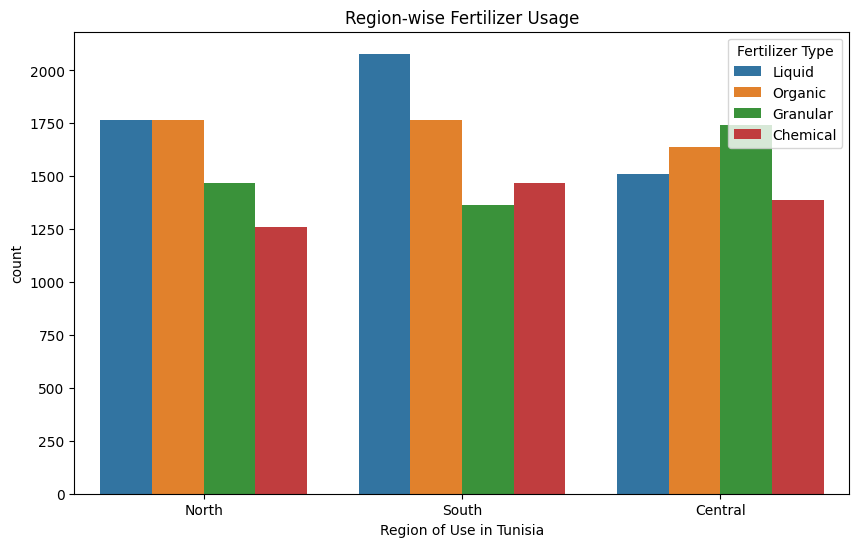

In [13]:
# 3. Region-wise Fertilizer Usage
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='Region of Use in Tunisia', hue='Fertilizer Type')
plt.title("Region-wise Fertilizer Usage")
plt.show()


North: Prefers Liquid & Organic fertilizers.
South: Highest Liquid fertilizer use (~100 count).
Central: More Chemical fertilizers used than other regions.
🔹 Modeling Insight: Region is a key factor in fertilizer recommendation. Consider interaction effects between Region & Fertilizer Type.

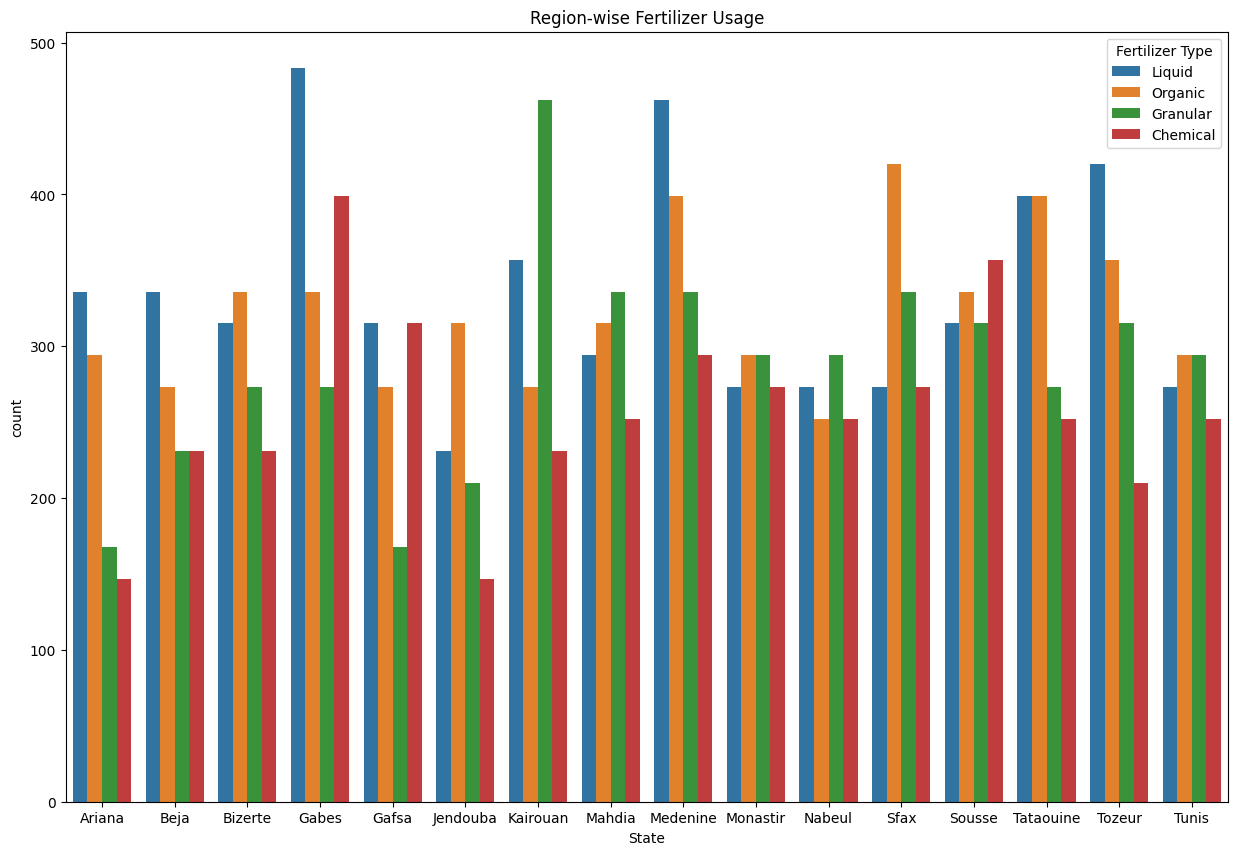

In [14]:
# State wise Fertilizer Usage
plt.figure(figsize=(15, 10))
sns.countplot(data=data, x='State', hue='Fertilizer Type')
plt.title("Region-wise Fertilizer Usage")
plt.show()


# **Data Preparation**

In [15]:
# -----------------------------------
# 1. CONVERT NUMERIC STRINGS TO FLOAT
# -----------------------------------
numeric_columns = [
    'N (%)', 'P (%)', 'K (%)', 'Absorption Rate (%)', 'Price per kg (TND)',
    'Soil_N', 'Soil_P', 'Soil_K', 'Crop N', 'Crop P', 'Crop K',
    'Root Depth (cm)', 'pH', 'Usage (Dosage)'
]
for col in numeric_columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')

In [16]:
# Using IQR method to handle outliers
for col in numeric_columns:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data[col] = np.where(data[col] < lower_bound, lower_bound, data[col])
    data[col] = np.where(data[col] > upper_bound, upper_bound, data[col])

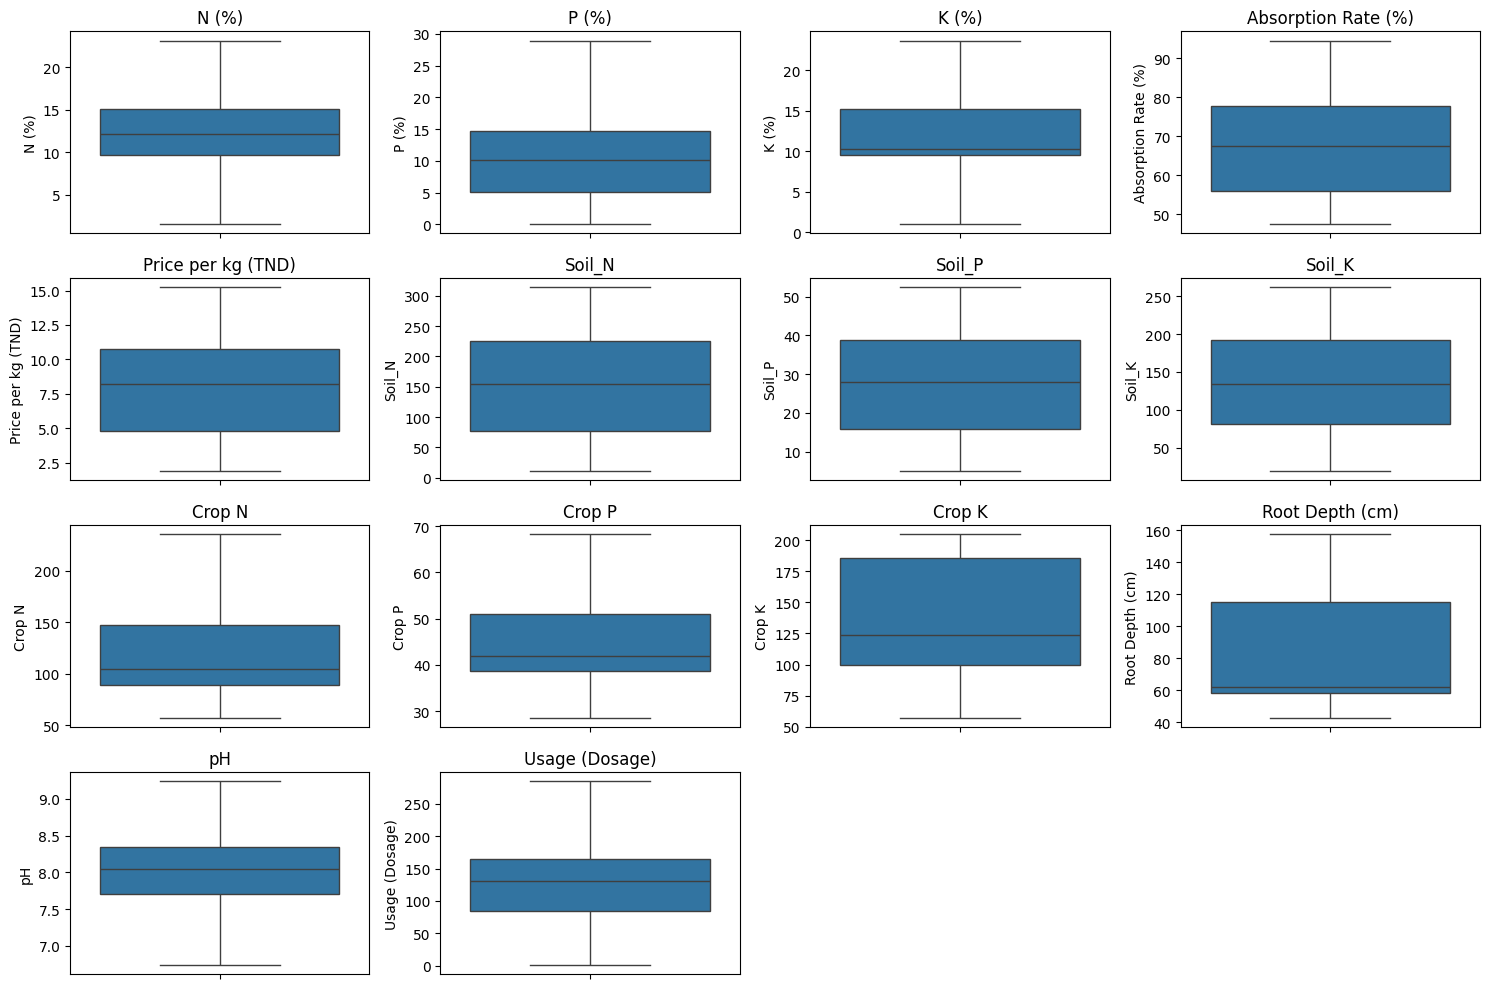

In [17]:
# 5. Check for Outliers
# Visualize outliers using boxplots for numerical columns
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_columns):
    plt.subplot(4, 4, i+1)
    sns.boxplot(y=data[col])
    plt.title(col)
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Nitrogen (N) Distribution')

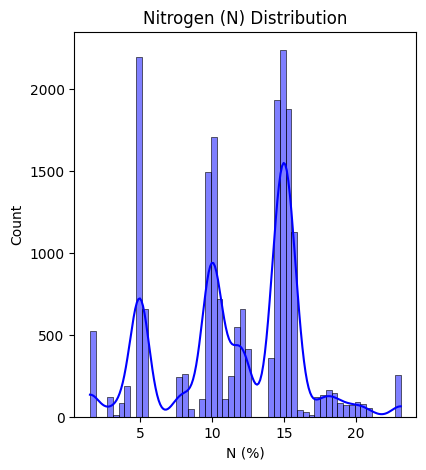

In [18]:
# =============================================
# 3. EXPLORATORY DATA ANALYSIS (EDA)
# =============================================

# Nutrient composition analysis
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.histplot(data['N (%)'], kde=True, color='blue')
plt.title('Nitrogen (N) Distribution')



Text(0.5, 1.0, 'Phosphorus (P) Distribution')

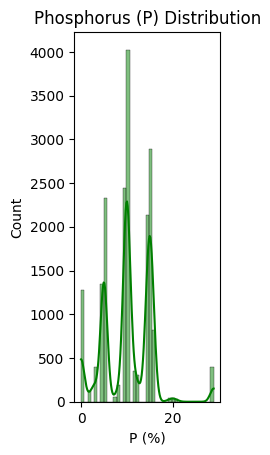

In [19]:
plt.subplot(1, 3, 2)
sns.histplot(data['P (%)'], kde=True, color='green')
plt.title('Phosphorus (P) Distribution')



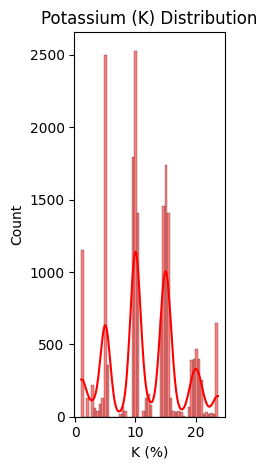

In [20]:
plt.subplot(1, 3, 3)
sns.histplot(data['K (%)'], kde=True, color='red')
plt.title('Potassium (K) Distribution')
plt.tight_layout()
plt.show()

<ipython-input-21-6b8539a69c21>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Fertilizer Type', data=data, palette='viridis')


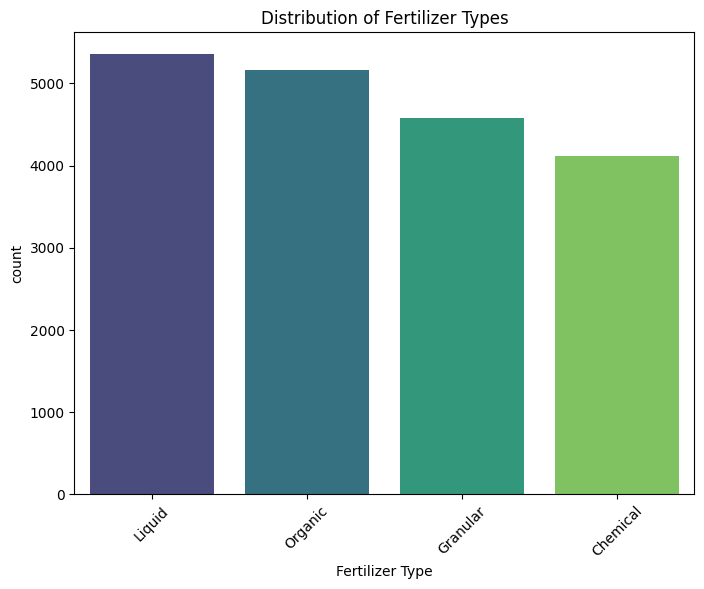

In [21]:
# Fertilizer type distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='Fertilizer Type', data=data, palette='viridis')
plt.title('Distribution of Fertilizer Types')
plt.xticks(rotation=45)
plt.show()

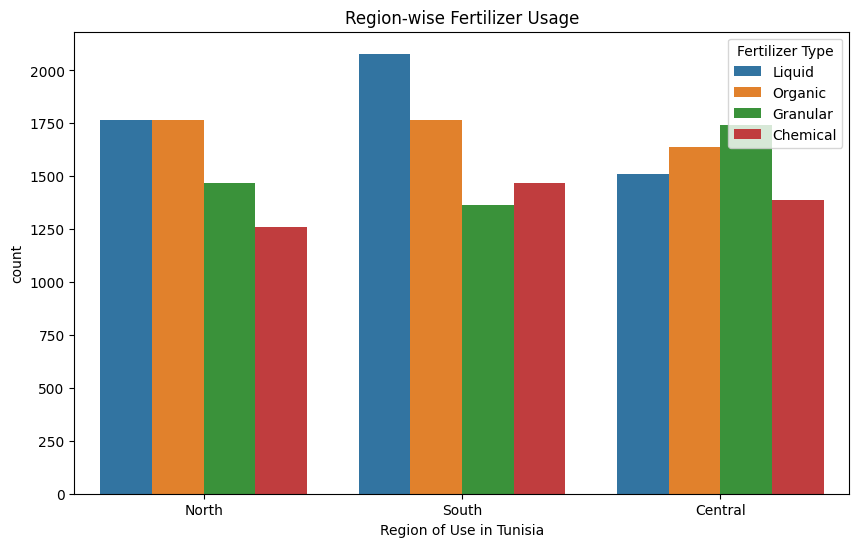

In [22]:
# Region-wise usage
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='Region of Use in Tunisia', hue='Fertilizer Type')
plt.title("Region-wise Fertilizer Usage")
plt.show()

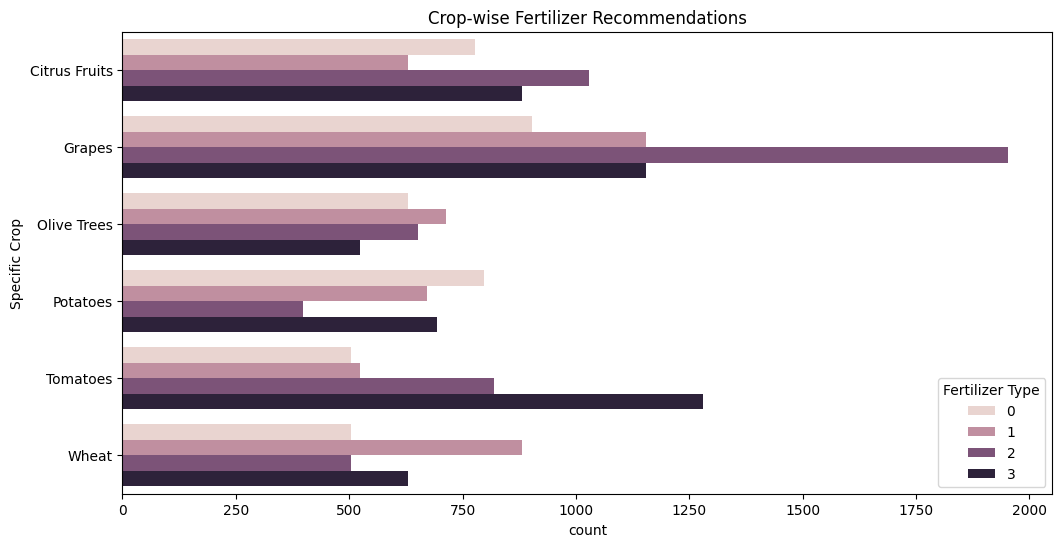

In [47]:
# 4. Crop-wise Fertilizer Recommendations
plt.figure(figsize=(12, 6))
sns.countplot(data=data, y='Specific Crop', hue='Fertilizer Type')
plt.title("Crop-wise Fertilizer Recommendations")
plt.show()

Grapes receive the highest liquid fertilizer usage.
Tomatoes are more associated with organic fertilizers.

In [23]:
# Key nutrient deficits ,This directly measures how much of each nutrient the soil is lacking)
data['N_Abs_Deficit'] = abs(data["Crop N"] - data["Soil_N"])
data['P_Abs_Deficit'] = abs(data['Crop P'] - data['Soil_P'])
data['K_Abs_Deficit'] = abs(data['Crop K'] - data['Soil_K'])


data['Absorption_Factor'] = data['Absorption Rate (%)'] / 100
# Application method impact
app_method_map = {
    'Radicular': 0.8,   # 80% efficiency
    'Foliar': 0.6,      # 60% (absorbs less)
    'Soil Application': 1.0,  # Baseline
    'Radicular and Foliar': 0.7,
    'Radicular and Soil Application': 0.9
}
data['Method_Efficiency'] = data['Application Method'].map(app_method_map).fillna(1.0)

data['Fert_Match'] = (
    0.5 * (data['N (%)'] / data['Crop N'].clip(lower=1)) +
    0.3 * (data['P (%)'] / data['Crop P'].clip(lower=1)) +
    0.2 * (data['K (%)'] / data['Crop K'].clip(lower=1))
)


data['Adj_N_Deficit'] = data['N_Abs_Deficit'] / (data['Absorption_Factor'] * data['Method_Efficiency'])
data['Adj_P_Deficit'] = data['P_Abs_Deficit'] / (data['Absorption_Factor'] * data['Method_Efficiency'])
data['Adj_K_Deficit'] = data['K_Abs_Deficit'] / (data['Absorption_Factor'] * data['Method_Efficiency'])



Top correlated features with Usage (Dosage):
Usage (Dosage)         1.000000
Crop N                 0.351220
Crop P                 0.308031
Root Depth (cm)        0.307984
Adj_P_Deficit          0.176989
P_Abs_Deficit          0.174962
pH                     0.162542
Adj_K_Deficit          0.115009
K_Abs_Deficit          0.113331
Crop K                 0.104255
N (%)                  0.103903
P (%)                  0.098618
Price per kg (TND)     0.098072
K (%)                  0.031600
Soil_P                 0.002006
Soil_N                 0.001463
Adj_N_Deficit         -0.011127
Soil_K                -0.011327
Absorption_Factor     -0.032173
Absorption Rate (%)   -0.032173
N_Abs_Deficit         -0.041572
Method_Efficiency     -0.070464
Fert_Match            -0.124151
Name: Usage (Dosage), dtype: float64


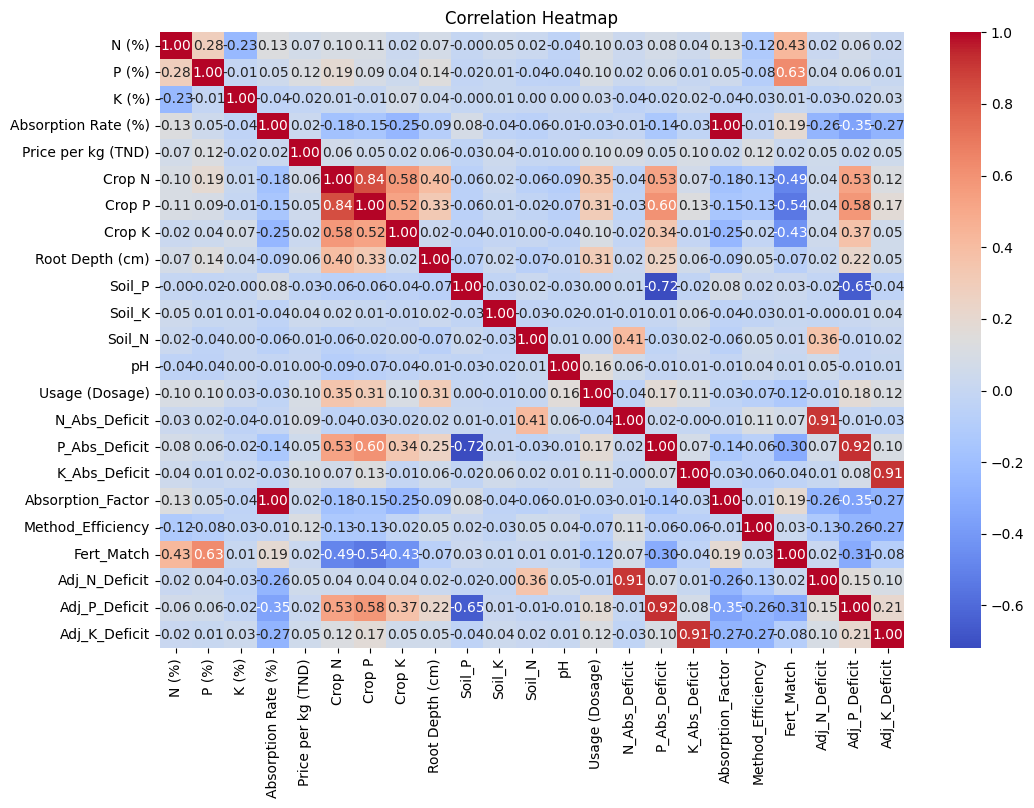

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numeric features
numerical_features = data.select_dtypes(include=['float64', 'int64'])

# Compute correlation with the target
correlation_with_target = numerical_features.corr()['Usage (Dosage)'].sort_values(ascending=False)

# Display top correlations
print("Top correlated features with Usage (Dosage):")
print(correlation_with_target)

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(numerical_features.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap")
plt.show()


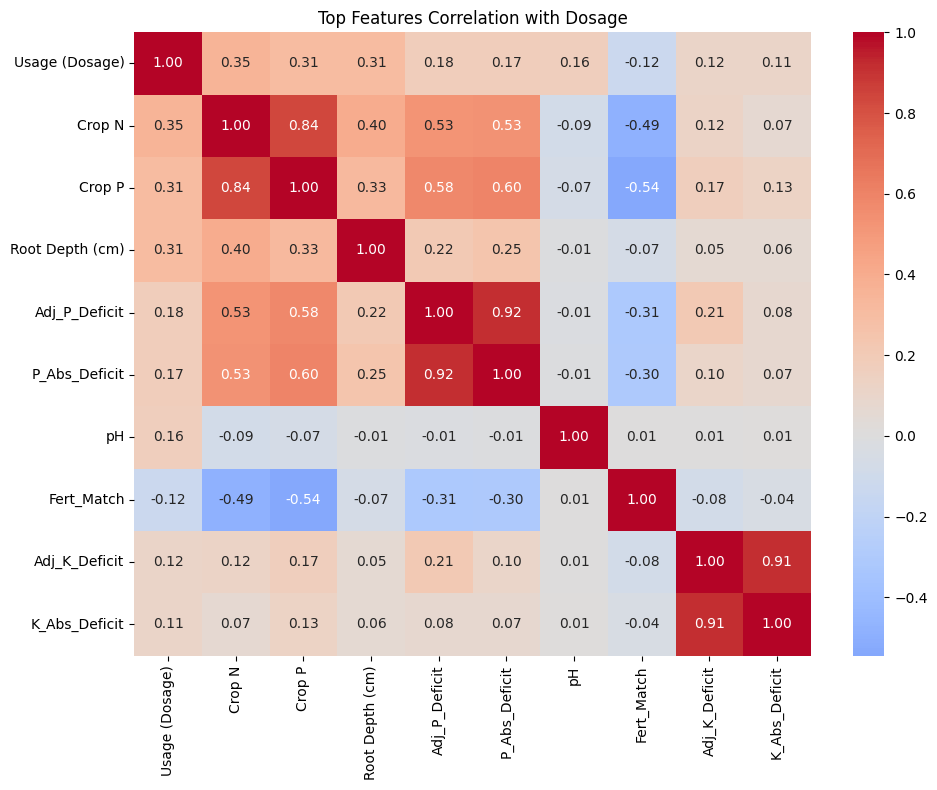

In [25]:
# Select top 10 features most correlated with dosage
top_features = correlation_with_target.abs().sort_values(ascending=False).index[:10]
focused_corr = numerical_features[top_features].corr()

# Create a smaller heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(focused_corr, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title("Top Features Correlation with Dosage")
plt.tight_layout()
plt.show()

In [26]:
# Get top 10 features correlated with dosage
top_features = correlation_with_target.abs().sort_values(ascending=False).index[:10]
top_correlations = correlation_with_target[top_features]

# Print formatted correlation report
print("="*60)
print("FERTILIZER DOSAGE CORRELATION ANALYSIS REPORT")
print("="*60)

print("\nTOP FEATURES CORRELATED WITH DOSAGE (Usage (Dosage)):")
print("-"*55)
for feature, corr in top_correlations.items():
    strength = ""
    if abs(corr) >= 0.7: strength = "VERY STRONG"
    elif abs(corr) >= 0.5: strength = "STRONG"
    elif abs(corr) >= 0.3: strength = "MODERATE"
    else: strength = "WEAK"

    direction = "increases with" if corr > 0 else "decreases with"
    print(f"{feature:>20}: {corr:.2f} ({strength} {direction} dosage)")

# Get inter-feature correlations
print("\nTOP INTER-FEATURE CORRELATIONS (Potential Multicollinearity):")
print("-"*55)
focused_corr = numerical_features[top_features].corr().abs()

# Get top 5 inter-feature correlations (excluding self-correlation and duplicates)
corr_pairs = (focused_corr.where(np.triu(np.ones(focused_corr.shape), k=1).astype(bool))
              .stack()
              .sort_values(ascending=False)
              .head(5))

for (feature1, feature2), corr in corr_pairs.items():
    print(f"{feature1:>20} ↔ {feature2:<20}: {corr:.2f}")



FERTILIZER DOSAGE CORRELATION ANALYSIS REPORT

TOP FEATURES CORRELATED WITH DOSAGE (Usage (Dosage)):
-------------------------------------------------------
      Usage (Dosage): 1.00 (VERY STRONG increases with dosage)
              Crop N: 0.35 (MODERATE increases with dosage)
              Crop P: 0.31 (MODERATE increases with dosage)
     Root Depth (cm): 0.31 (MODERATE increases with dosage)
       Adj_P_Deficit: 0.18 (WEAK increases with dosage)
       P_Abs_Deficit: 0.17 (WEAK increases with dosage)
                  pH: 0.16 (WEAK increases with dosage)
          Fert_Match: -0.12 (WEAK decreases with dosage)
       Adj_K_Deficit: 0.12 (WEAK increases with dosage)
       K_Abs_Deficit: 0.11 (WEAK increases with dosage)

TOP INTER-FEATURE CORRELATIONS (Potential Multicollinearity):
-------------------------------------------------------
       Adj_P_Deficit ↔ P_Abs_Deficit       : 0.92
       Adj_K_Deficit ↔ K_Abs_Deficit       : 0.91
              Crop N ↔ Crop P              :

In [27]:
# Drop only one of each high-corr pair to reduce redundancy
data = data.drop(columns=['P_Abs_Deficit', 'K_Abs_Deficit'], errors='ignore')


In [28]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

# -------------------------------
# 5. HANDLE CATEGORICAL VARIABLES
# -------------------------------
label_cols = ['Fertilizer Name', 'Fertilizer Type', 'Region of Use in Tunisia', 'Application Method']
le = LabelEncoder()
for col in label_cols:
    data[col] = le.fit_transform(data[col])

In [29]:
# -------------------------------
# 6. LOG TRANSFORM HIGHLY SKEWED
# -------------------------------
skewed = data[numeric_columns].skew()
to_log = skewed[abs(skewed) > 1.5].index
data[to_log] = data[to_log].apply(lambda x: np.log1p(x))
print("🔁 Log-transformed:", list(to_log))

# Recheck skewness after log
print("\n📈 Skewness after log transformation:")
print(data[to_log].skew())

🔁 Log-transformed: []

📈 Skewness after log transformation:
Series([], dtype: float64)


In [30]:
# ----------------------------------
# 7. SCALE NUMERIC FEATURES
# ----------------------------------
features_to_scale = [
    'Crop N', 'Crop P', 'Crop K', 'Root Depth (cm)', 'pH',
    'N (%)', 'P (%)', 'K (%)', 'Price per kg (TND)',
    'Adj_P_Deficit', 'Adj_K_Deficit', 'Fert_Match', 'Absorption Rate (%)'
]
scaler = StandardScaler()
data[features_to_scale] = scaler.fit_transform(data[features_to_scale])

🔍 Missing values: 0


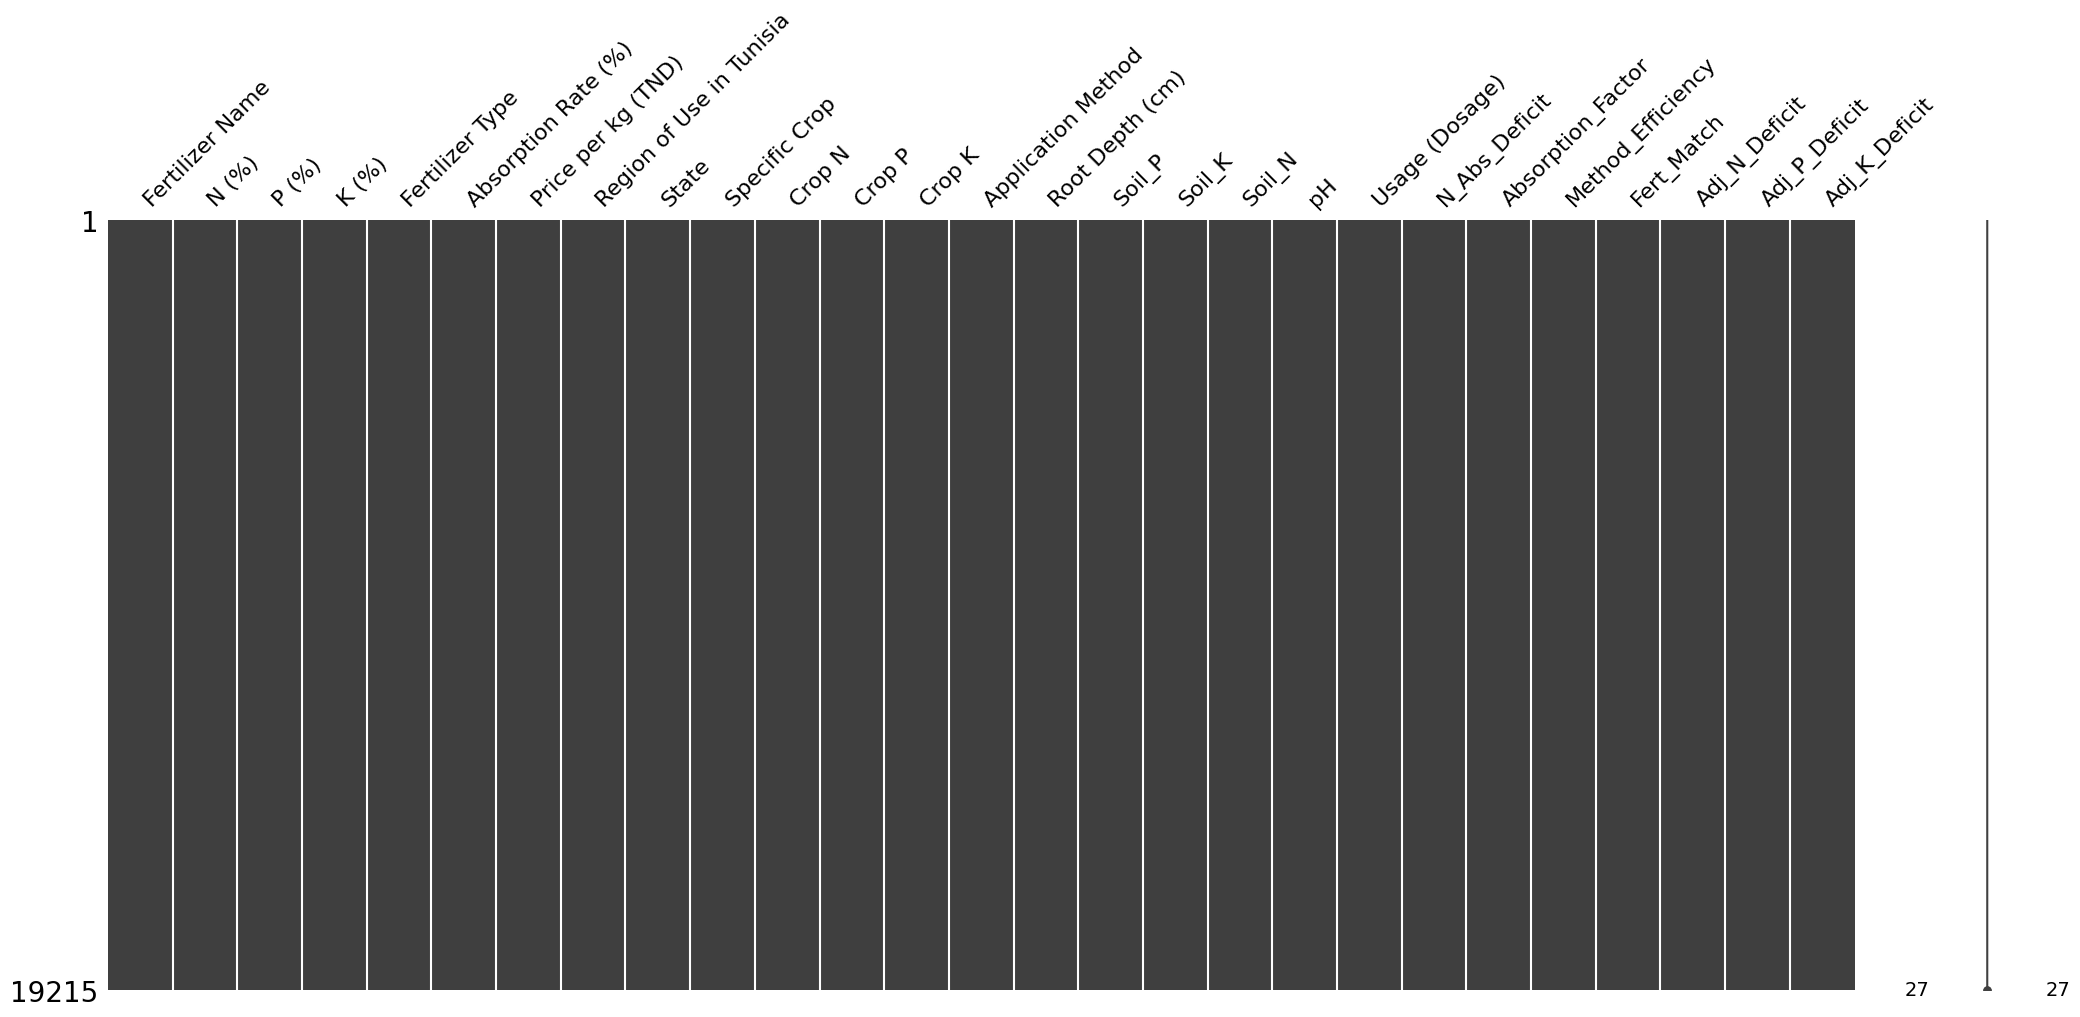

In [31]:
# -----------------------------
# 8. CHECK MISSING DATA
# -----------------------------
print("🔍 Missing values:", data.isnull().sum().sum())
msno.matrix(data)
plt.show()

In [32]:
# -----------------------------
# 9. FINAL TRAIN-TEST SPLIT
# -----------------------------
X = data.drop(columns=['Usage (Dosage)', 'State', 'Specific Crop'])  # exclude target and descriptive fields
y = data['Usage (Dosage)']

In [33]:
from sklearn.preprocessing import PolynomialFeatures

# ======================================
# 9. Optional: Polynomial Features
# ======================================
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)


In [34]:
# 🧠 Focus on top 10 important features from earlier correlation
top_features = [
    'Adj_N_Deficit', 'Fert_Match', 'Crop N', 'Crop P', 'Crop K',
    'Root Depth (cm)', 'pH', 'Absorption Rate (%)',
    'Price per kg (TND)', 'Adj_K_Deficit'
]
X = X[top_features]

In [35]:
# ============================
# 10. Train-Test Split
# ============================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("✅ Final train-test shape:", X_train.shape, X_test.shape)


✅ Final train-test shape: (15372, 10) (3843, 10)


## **Modeling + Evaluation**

**Random Forest Regressor**

In [36]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Preprocessing
numeric_features = X.columns
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features)
])

# Pipeline
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Hyperparameters
rf_param_dist = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [10, 20, None],
    'regressor__min_samples_split': [2, 5],
    'regressor__min_samples_leaf': [1, 2]
}

# RandomizedSearchCV
rf_search = RandomizedSearchCV(
    rf_pipeline, rf_param_dist,
    n_iter=20, cv=3, n_jobs=-1, verbose=2,
    scoring='neg_root_mean_squared_error', random_state=42
)

rf_search.fit(X_train, y_train)
y_pred_rf = rf_search.best_estimator_.predict(X_test)

# Evaluation
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("✅ Best Parameters (RF):", rf_search.best_params_)
print(f"📉 MAE: {mae_rf:.2f} | RMSE: {rmse_rf:.2f} | R²: {r2_rf:.4f}")


Fitting 3 folds for each of 20 candidates, totalling 60 fits
✅ Best Parameters (RF): {'regressor__n_estimators': 300, 'regressor__min_samples_split': 2, 'regressor__min_samples_leaf': 1, 'regressor__max_depth': None}
📉 MAE: 15.61 | RMSE: 23.91 | R²: 0.8479


**XGBRegressor**

In [39]:
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# 🔄 XGBoost Pipeline
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(objective='reg:squarederror', random_state=42))
])

# 🎯 Expanded hyperparameter distribution
xgb_param_dist = {
    'regressor__n_estimators': [100, 150, 200],
    'regressor__max_depth': [3, 5, 7, 10],
    'regressor__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'regressor__subsample': [0.6, 0.8, 1.0],
    'regressor__colsample_bytree': [0.6, 0.8, 1.0],
    'regressor__gamma': [0, 0.1, 0.2],
    'regressor__reg_alpha': [0, 0.1, 1],
    'regressor__reg_lambda': [1, 1.5, 2]
}


# 🔍 RandomizedSearchCV setup
xgb_search = RandomizedSearchCV(
    xgb_pipeline,
    xgb_param_dist,
    n_iter=30,                  # More iterations = better search
    cv=3,
    n_jobs=-1,
    verbose=2,
    scoring='neg_root_mean_squared_error',
    random_state=42
)

print("🚀 Training XGBoost Regressor with Expanded Search Space...")
xgb_search.fit(X_train, y_train)

# 📈 Predictions
y_pred_xgb = xgb_search.best_estimator_.predict(X_test)

# 📊 Evaluation
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

# ✅ Results
print("✅ Best Parameters:", xgb_search.best_params_)
print(f"📉 MAE: {mae_xgb:.2f}")
print(f"📉 MSE: {mse_xgb:.2f}")
print(f"📉 RMSE: {rmse_xgb:.2f}")
print(f"📊 R²: {r2_xgb:.4f}")


🚀 Training XGBoost Regressor with Expanded Search Space...
Fitting 3 folds for each of 30 candidates, totalling 90 fits
✅ Best Parameters: {'regressor__subsample': 0.8, 'regressor__reg_lambda': 2, 'regressor__reg_alpha': 1, 'regressor__n_estimators': 100, 'regressor__max_depth': 10, 'regressor__learning_rate': 0.1, 'regressor__gamma': 0.2, 'regressor__colsample_bytree': 1.0}
📉 MAE: 14.95
📉 MSE: 505.56
📉 RMSE: 22.48
📊 R²: 0.8655


**Ridge Regression**

In [40]:
from sklearn.linear_model import Ridge

ridge_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Ridge(random_state=42))
])

ridge_pipeline.fit(X_train, y_train)
y_pred_ridge = ridge_pipeline.predict(X_test)

# Evaluation
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mse_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

print(f"📉 MAE: {mae_ridge:.2f} | RMSE: {rmse_ridge:.2f} | R²: {r2_ridge:.4f}")


📉 MAE: 41.37 | RMSE: 54.57 | R²: 0.2076


** Gradient Boosting Regressor**

In [41]:
from sklearn.ensemble import GradientBoostingRegressor

gbr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(random_state=42))
])

gbr_param_dist = {
    'regressor__n_estimators': [100, 150, 200],
    'regressor__learning_rate': [0.01, 0.05, 0.1],
    'regressor__max_depth': [3, 5, 7],
    'regressor__min_samples_split': [2, 5],
    'regressor__min_samples_leaf': [1, 2]
}

gbr_search = RandomizedSearchCV(
    gbr_pipeline, gbr_param_dist,
    n_iter=20, cv=3, n_jobs=-1, verbose=2,
    scoring='neg_root_mean_squared_error', random_state=42
)

gbr_search.fit(X_train, y_train)
y_pred_gbr = gbr_search.best_estimator_.predict(X_test)

# Evaluation
mae_gbr = mean_absolute_error(y_test, y_pred_gbr)
mse_gbr = mean_squared_error(y_test, y_pred_gbr)
rmse_gbr = np.sqrt(mse_gbr)
r2_gbr = r2_score(y_test, y_pred_gbr)

print("✅ Best Parameters (GBR):", gbr_search.best_params_)
print(f"📉 MAE: {mae_gbr:.2f} | RMSE: {rmse_gbr:.2f} | R²: {r2_gbr:.4f}")


Fitting 3 folds for each of 20 candidates, totalling 60 fits
✅ Best Parameters (GBR): {'regressor__n_estimators': 150, 'regressor__min_samples_split': 5, 'regressor__min_samples_leaf': 2, 'regressor__max_depth': 7, 'regressor__learning_rate': 0.1}
📉 MAE: 21.88 | RMSE: 29.96 | R²: 0.7612


# 📊 Step 4: Compare Model Performance

**✅ 1. Model Comparison Table**

In [42]:
import pandas as pd

# Create a comparison DataFrame
results = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost', 'Gradient Boosting', 'Ridge Regression'],
    'MAE': [mae_rf, mae_xgb, mae_gbr, mae_ridge],
    'MSE': [mse_rf, mse_xgb, mse_gbr, mse_ridge],
    'RMSE': [rmse_rf, rmse_xgb, rmse_gbr, rmse_ridge],
    'R²': [r2_rf, r2_xgb, r2_gbr, r2_ridge]
})

# Show the sorted table by RMSE (lower is better)
print("📊 Model Comparison Table:")
display(results.sort_values(by='RMSE'))


📊 Model Comparison Table:


,Model,MAE,MSE,RMSE,R²
1,XGBoost,14.952225,505.562086,22.484708,0.865483
0,Random Forest,15.612122,571.698878,23.910225,0.847886
2,Gradient Boosting,21.878889,897.676674,29.961253,0.761151
3,Ridge Regression,41.374244,2978.025066,54.571284,0.207624


## 🧠 Final Model Performance Summary

---

### 🥇 **XGBoost Regressor**
- ✅ **Best overall model** — lowest **MAE = 14.95**, **RMSE = 22.48**, highest **R² = 0.865**
- 🚀 Hyperparameter tuning **significantly improved** performance
- ✅ **Recommended for production** use due to robustness and accuracy
- 💡 *Tip:* For better generalization, add `early_stopping_rounds` and use `n_jobs=-1` for faster training

---

### 🥈 **Random Forest Regressor**
- 🌲 Strong and **reliable runner-up**
- Very close to XGBoost in performance
- ✅ Excellent choice for **fast training** and **interpretability**
- ⚙️ Tuned using `RandomizedSearchCV` across multiple tree parameters

---

### 🥉 **Gradient Boosting Regressor**
- 🔥 Delivered **moderate performance**
- Higher **RMSE = 29.96** and lower **R² = 0.761**
- ⚠️ Could benefit from **early stopping** and **further tuning**
- 🧪 More suitable for **experimentation** than deployment

---

### ❌ **Ridge Regression**
- ➖ Significantly **underperformed**
- Very high **RMSE = 54.57** and low **R² = 0.207**
- 🚫 Not suited for this **nonlinear regression** problem
- Serves only as a **baseline model**

---


**📊 2. Bar Chart of Metrics (MAE, RMSE, R²)**

<ipython-input-43-e756e7e1f3e5>:21: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-43-e756e7e1f3e5>:21: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


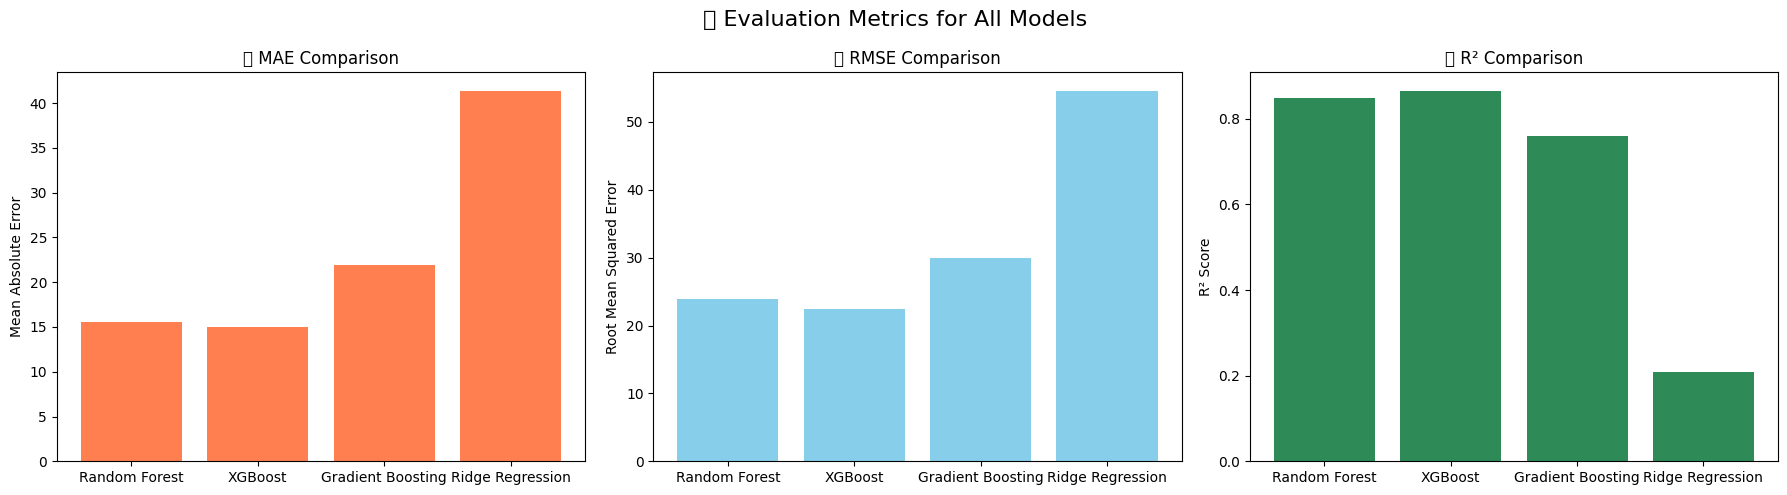

In [43]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# MAE
axs[0].bar(results['Model'], results['MAE'], color='coral')
axs[0].set_title('📉 MAE Comparison')
axs[0].set_ylabel('Mean Absolute Error')

# RMSE
axs[1].bar(results['Model'], results['RMSE'], color='skyblue')
axs[1].set_title('📉 RMSE Comparison')
axs[1].set_ylabel('Root Mean Squared Error')

# R²
axs[2].bar(results['Model'], results['R²'], color='seagreen')
axs[2].set_title('📊 R² Comparison')
axs[2].set_ylabel('R² Score')

plt.suptitle('📊 Evaluation Metrics for All Models', fontsize=16)
plt.tight_layout()
plt.show()


**📈 3. Actual vs Predicted Plot (All Models)**

<ipython-input-44-fd5e1e2239ee>:13: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


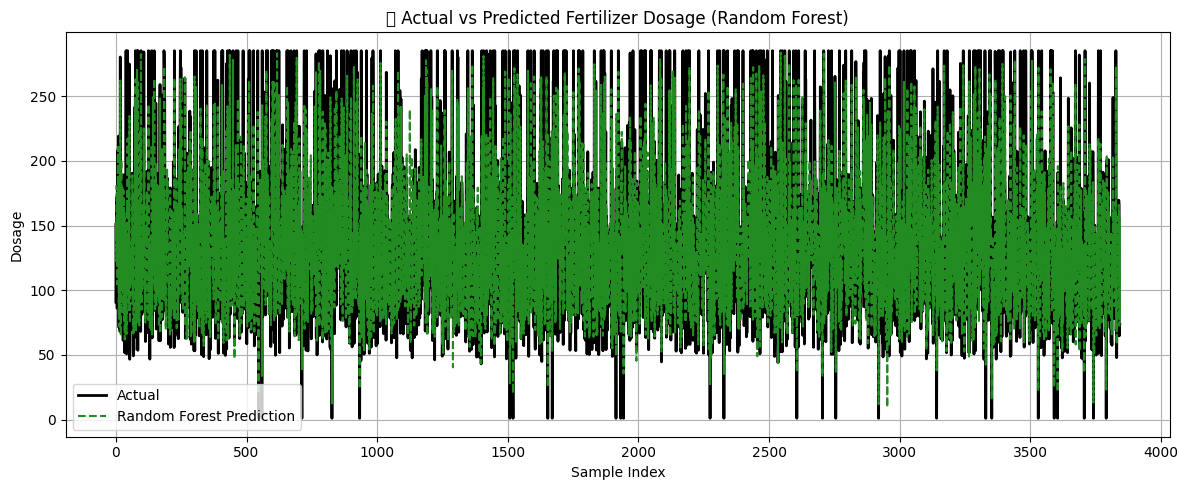

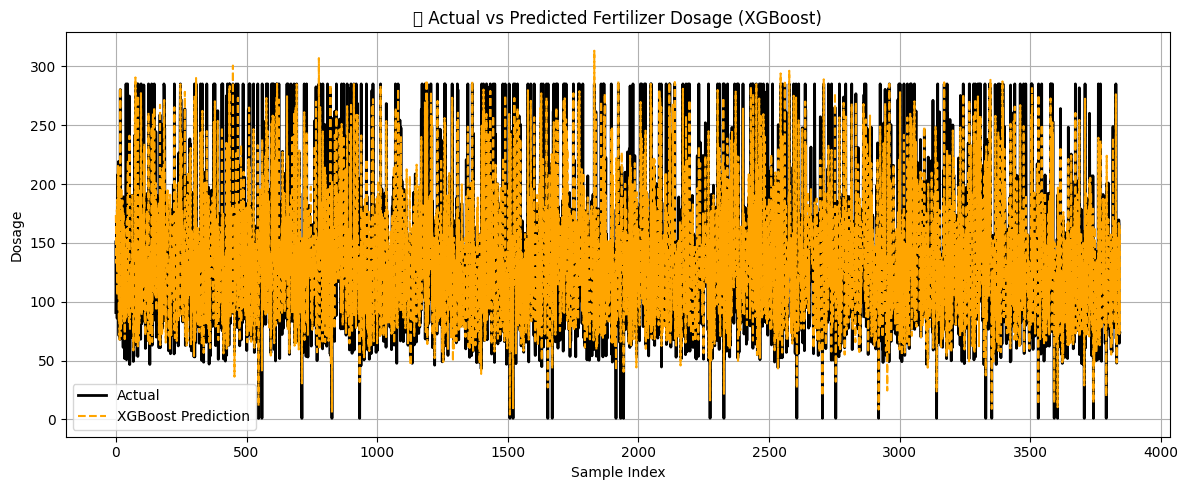

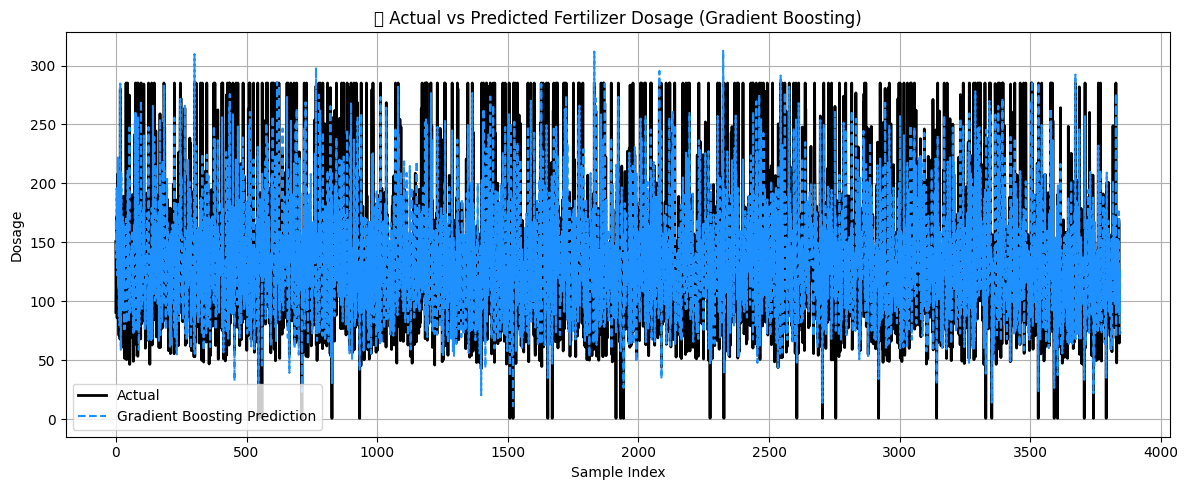

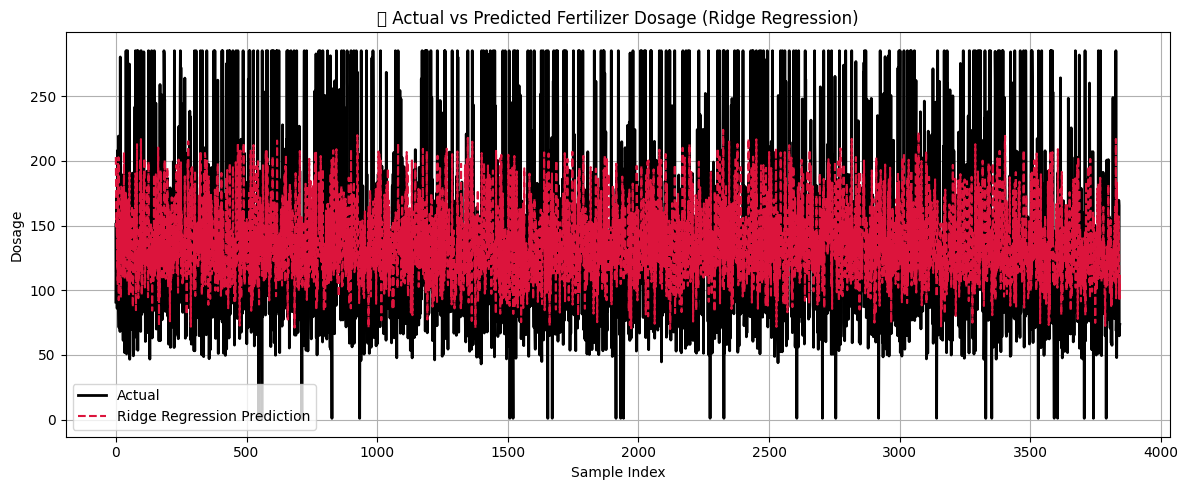

In [44]:
import matplotlib.pyplot as plt

# Function to plot actual vs predicted for a model
def plot_model_predictions(y_true, y_pred, model_name, color='blue'):
    plt.figure(figsize=(12, 5))
    plt.plot(y_true.values, label='Actual', color='black', linewidth=2)
    plt.plot(y_pred, label=f'{model_name} Prediction', linestyle='--', color=color)
    plt.title(f'📈 Actual vs Predicted Fertilizer Dosage ({model_name})')
    plt.xlabel('Sample Index')
    plt.ylabel('Dosage')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 🔹 Random Forest
plot_model_predictions(y_test, y_pred_rf, 'Random Forest', color='forestgreen')

# 🔹 XGBoost
plot_model_predictions(y_test, y_pred_xgb, 'XGBoost', color='orange')

# 🔹 Gradient Boosting
plot_model_predictions(y_test, y_pred_gbr, 'Gradient Boosting', color='dodgerblue')

# 🔹 Ridge Regression
plot_model_predictions(y_test, y_pred_ridge, 'Ridge Regression', color='crimson')


In [45]:
!pip install shap


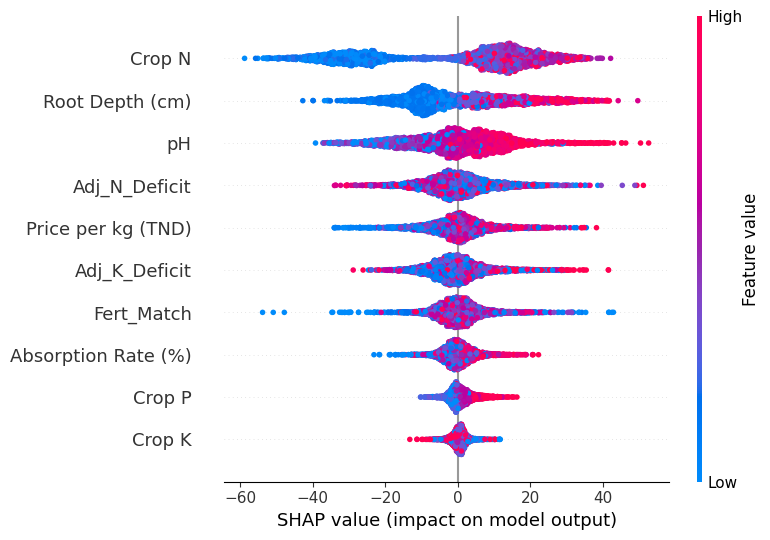

In [46]:
import shap

# Extract trained XGBoost model and transformed data
best_xgb_model = xgb_search.best_estimator_.named_steps['regressor']
X_test_transformed = preprocessor.transform(X_test)

# SHAP Explainer
explainer = shap.Explainer(best_xgb_model)
shap_values = explainer(X_test_transformed)

# Summary Plot
shap.summary_plot(shap_values, X_test_transformed, feature_names=X.columns.tolist())


This SHAP summary plot helps us interpret the XGBoost model by showing how each feature contributes to the prediction of fertilizer dosage.

# **🔍 Key Takeaways:**

**Crop N (nitrogen need)** is the most influential feature. Higher values (red) tend to increase dosage predictions.

**Root Depth, pH, and Adjusted Nutrient Deficits (N & K)** also strongly impact the model output.

**Price per kg and Fert_Match** play a moderate role, balancing cost and suitability.

**Absorption Rate, Crop P, and Crop K** contribute less overall but still have meaningful effects in specific cases.

# **💡 Interpretation:**
*   When Crop N is high (red dots to the right), the model predicts a higher dosage.

*   When Root Depth is low (blue dots to the left), it pulls the prediction downward.

*   This plot provides a global view of feature importance and direction of impact, making your model more transparent and trustworthy.

